In [1]:
import pandas as pd

In [100]:
#pip install numexpr --upgrade

In [101]:
#pip install bottleneck --upgrade

In [15]:
import numpy as np

In [103]:
#pip install matplotlib

In [2]:
#pip install seaborn --upgrade

In [105]:
#pip install pandas --upgrade

In [106]:
#! pip install --upgrade pyodbc

In [107]:
#pip show matplotlib

In [108]:
#pip install matplotlib --upgrade

In [109]:
#!python --version

In [3]:
import matplotlib.pyplot as plt

In [16]:
import seaborn as sns

In [5]:
import geopandas
import pysal
import contextily
from sklearn.cluster import DBSCAN

In [113]:
#pip install --upgrade seaborn

In [114]:
#pip uninstall pandas --yes

In [115]:
#pip uninstall seaborn matplotlib --yes

In [116]:
#pip install fastparquet

In [117]:
#pip install seaborn matplotlib

In [118]:
#pip install pyarrow

In [119]:
#pip install pysal

In [120]:
#pip install contextily

In [6]:
hilo_full = pd.read_parquet('hilo_full_patterns.parquet')

In [7]:
hilo_full.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

In [8]:
hilo_full["longitude"]

2353     -155.080101
3153     -155.076062
3422     -155.084421
4179     -155.066791
9436     -155.079238
             ...    
506689   -155.087536
507478   -155.087844
514153   -155.041701
534386   -155.075917
540183   -155.088840
Name: longitude, Length: 47954, dtype: float64

In [9]:
hilo_full["latitude"]

2353      19.705079
3153      19.710198
3422      19.721123
4179      19.716826
9436      19.718644
            ...    
506689    19.724503
507478    19.725412
514153    19.718848
534386    19.710657
540183    19.722289
Name: latitude, Length: 47954, dtype: float64

In [10]:
hilo_full.reset_index(drop=True, inplace=True)

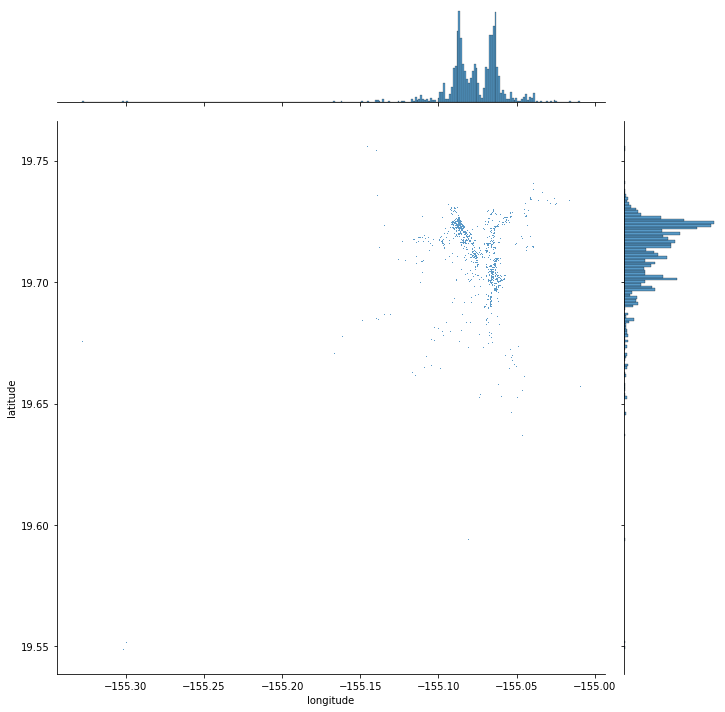

In [126]:
# Point pattern joint plot of longitude and latitude in the hilo_full_patterns dataset
# Scatter plot part shows the correlation between these variables
# Histogram on the sides shows the distribution of each variable independently

lat_long_relation = sns.jointplot(
    x="longitude", y="latitude", data=hilo_full, s=0.5, height=10
)
plt.show()
# We see dots are concentrated in the upper right quadrant of the covered area in a non-random pattern
# Localized clusters within the broader pattern

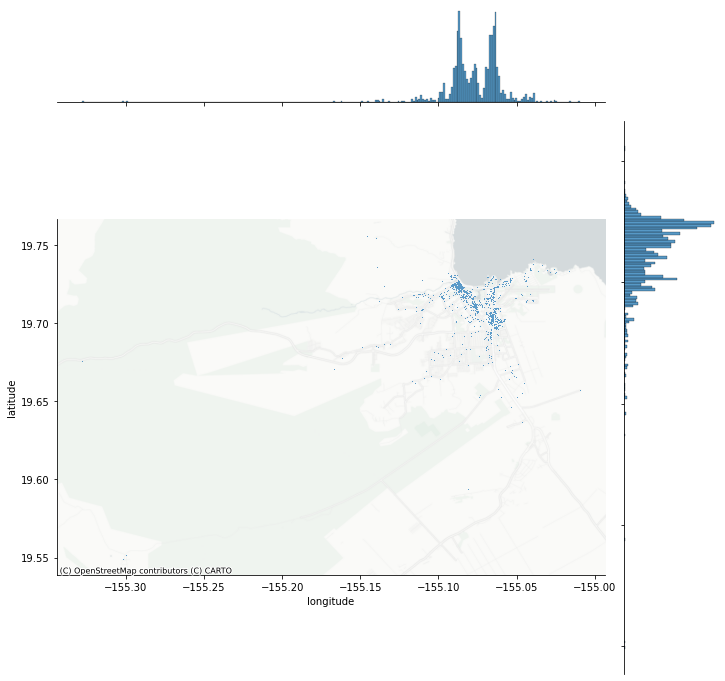

In [36]:
# Add geographical context
joint_axes = sns.jointplot(
    x="longitude", y="latitude", data=hilo_full, s=0.5, height=10
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    alpha=1,
);

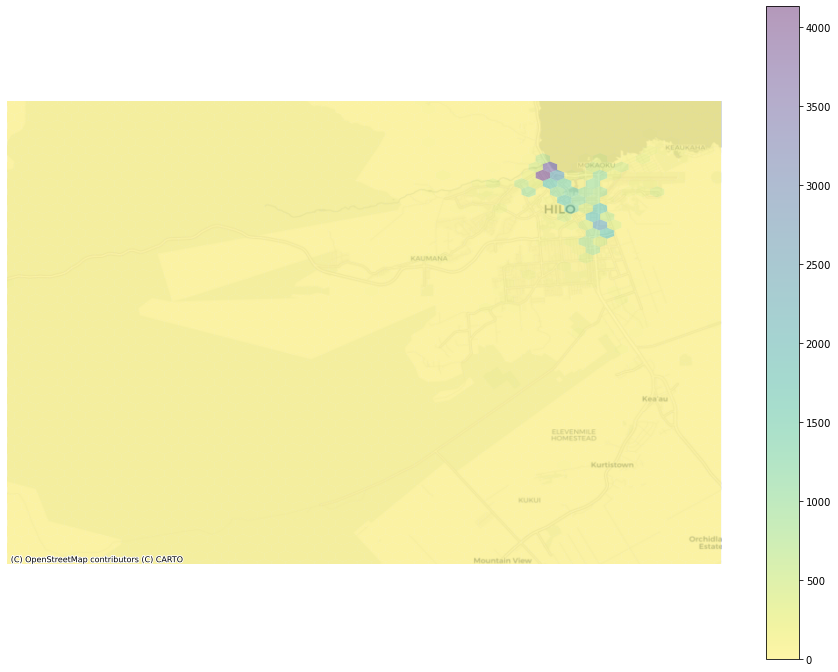

In [120]:
# Address cluttering problem by showing density: Hexbinning
fig, ax = plt.subplots(figsize=(16, 12))

# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hilo_full_hxb = ax.hexbin(hilo_full['longitude'], hilo_full['latitude'], gridsize=50, cmap='viridis_r', alpha=0.4, linewidths=0)

# Add basemap
xmin, xmax, ymin, ymax = [hilo_full['longitude'].min(), hilo_full['longitude'].max(), hilo_full['latitude'].min(), hilo_full['latitude'].max()]
contextily.add_basemap(ax, crs='EPSG:4326', source=contextily.providers.CartoDB.Positron, zoom=12)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.colorbar(hilo_full_hxb)
ax.set_axis_off()
plt.show()

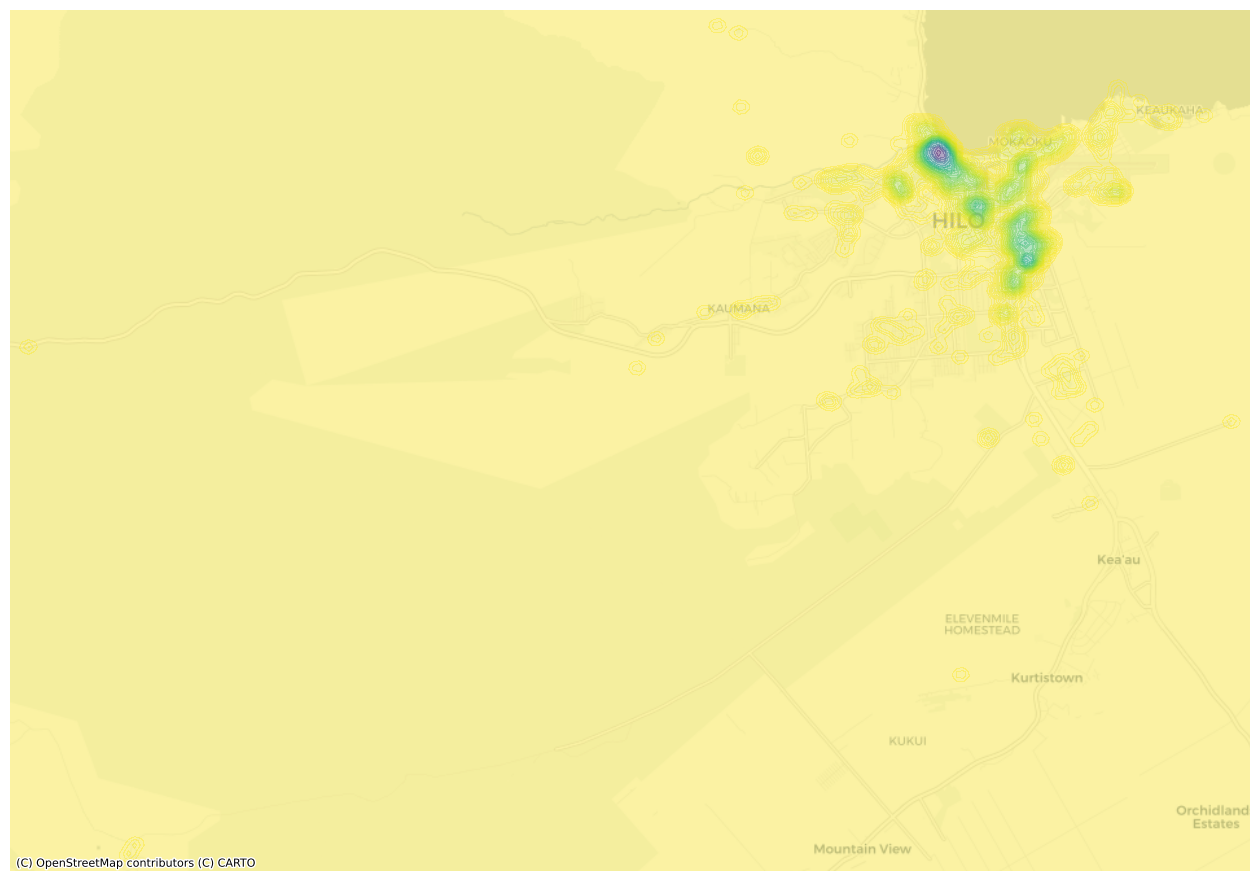

In [151]:
# Another kind of density visualization: Kernel Density Estimation
# Convert DataFrame to GeoDataFrame for easy CRS management
gdf = gpd.GeoDataFrame(hilo_full, geometry=gpd.points_from_xy(hilo_full.longitude, hilo_full.latitude))
gdf.crs = "EPSG:4326"  # Define the original CRS of the data

# Transform to Web Mercator for compatibility with contextily
gdf = gdf.to_crs(epsg=3857)

# Set up figure and axis for plotting
f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)

# Now plot KDE using the transformed coordinates
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    fill=True,
    thresh=0,
    levels=50,
    alpha=0.4,
    cmap="viridis_r",
    bw_adjust=0.5,
    ax=ax
)

# Adding the basemap without manually setting zoom allows contextily to auto-determine the best zoom level
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron, crs="EPSG:3857")

ax.set_axis_off()

plt.show()

In [12]:
from pointpats import centrography
import contextily as ctx
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.patches import Ellipse

In [17]:
# Check for missing or infinite values and drop them if necessary
hilo_full = hilo_full.dropna(subset=['longitude', 'latitude'])
hilo_full = hilo_full[(hilo_full['longitude'] != np.inf) & (hilo_full['latitude'] != np.inf)]
hilo_full = hilo_full[(hilo_full['longitude'] != -np.inf) & (hilo_full['latitude'] != -np.inf)]

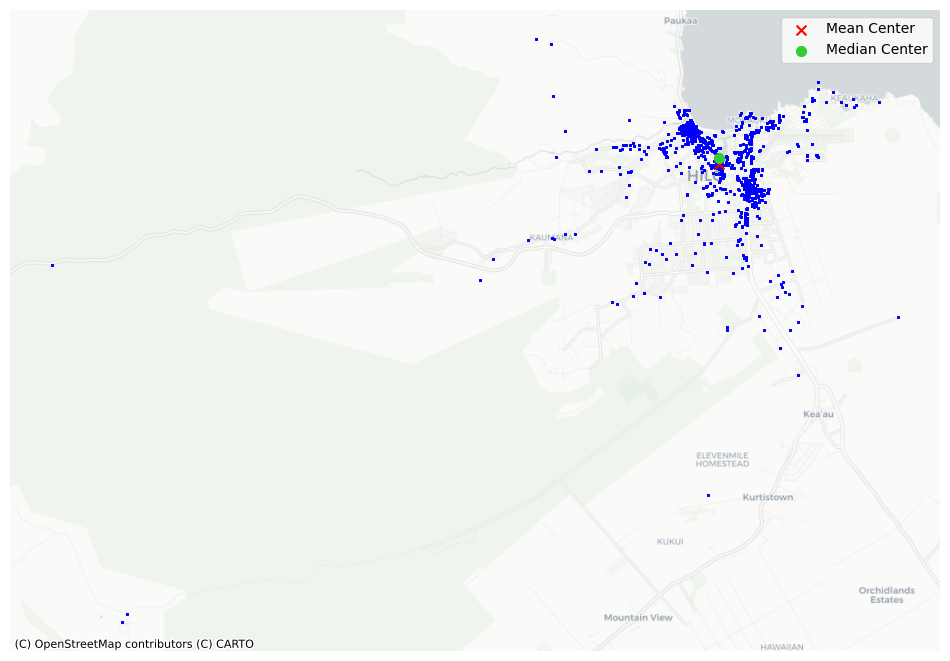

In [165]:
# Point pattern and mean center plot
mean_center = centrography.mean_center(hilo_full[["longitude", "latitude"]])
med_center = centrography.euclidean_median(hilo_full[["longitude", "latitude"]])

# Create a GeoDataFrame for the centers
centers_gdf = gpd.GeoDataFrame(geometry=[Point(mean_center), Point(med_center)], crs="EPSG:4326")

# Transform to Web Mercator
centers_gdf = centers_gdf.to_crs(epsg=3857)

# Extract transformed coordinates
mean_center_3857 = centers_gdf.geometry.iloc[0].x, centers_gdf.geometry.iloc[0].y
med_center_3857 = centers_gdf.geometry.iloc[1].x, centers_gdf.geometry.iloc[1].y

# Convert your DataFrame to a GeoDataFrame for easy CRS management
gdf = gpd.GeoDataFrame(hilo_full, geometry=gpd.points_from_xy(hilo_full.longitude, hilo_full.latitude), crs="EPSG:4326")

# Add mean and median center points to the joint_axes plot
joint_axes.ax_joint.scatter(*mean_center, color="red", marker="x", s=100, label="Mean Center")
joint_axes.ax_joint.scatter(*med_center, color="limegreen", marker="o", s=100, label="Median Center")

# Generate scatterplot using transformed GeoDataFrame
plt.figure(figsize=(12, 18), dpi=100)
ax = plt.gca()
gdf_3857.plot(ax=ax, color='blue', markersize=0.5, alpha=0.3)

# Add mean point and marginal lines in the transformed coordinates
ax.scatter(*mean_center_3857, color="red", marker="x", s=50, label="Mean Center")
#ax.axvline(mean_center_3857[0], color="red")
#ax.axhline(mean_center_3857[1], color="red")

# Add median point and marginal lines in the transformed coordinates
ax.scatter(*med_center_3857, color="limegreen", marker="o", s=50, label="Median Center")
#ax.axvline(med_center_3857[0], color="limegreen")
#ax.axhline(med_center_3857[1], color="limegreen")

# Legend
ax.legend()

# Add basemap
ctx.add_basemap(ax, crs=gdf_3857.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()  

plt.show()

In [173]:
# Standard distance calculation - measure of foot traffic dispersion from center of the point cloud

# Create a GeoDataFrame from the original data
gdf = gpd.GeoDataFrame(hilo_full, geometry=gpd.points_from_xy(hilo_full.longitude, hilo_full.latitude), crs="EPSG:4326")

# Transform the CRS to UTM (assuming EPSG:32604 for Hawaii)
gdf_utm = gdf.to_crs("EPSG:32604")

# Extract x and y coordinates from the geometry since std_distance expects numeric inputs
x, y = gdf_utm.geometry.x, gdf_utm.geometry.y

# Calculate the standard distance in the UTM projection
std_distance = centrography.std_distance(np.vstack((x, y)).T)

# Output the standard distance
print(f"The standard distance is approximately {std_distance} meters.")
# This means that on average, foot traffic occurs around 2700 meters away from the mean center.

The standard distance is approximately 2700.7610569284157 meters.


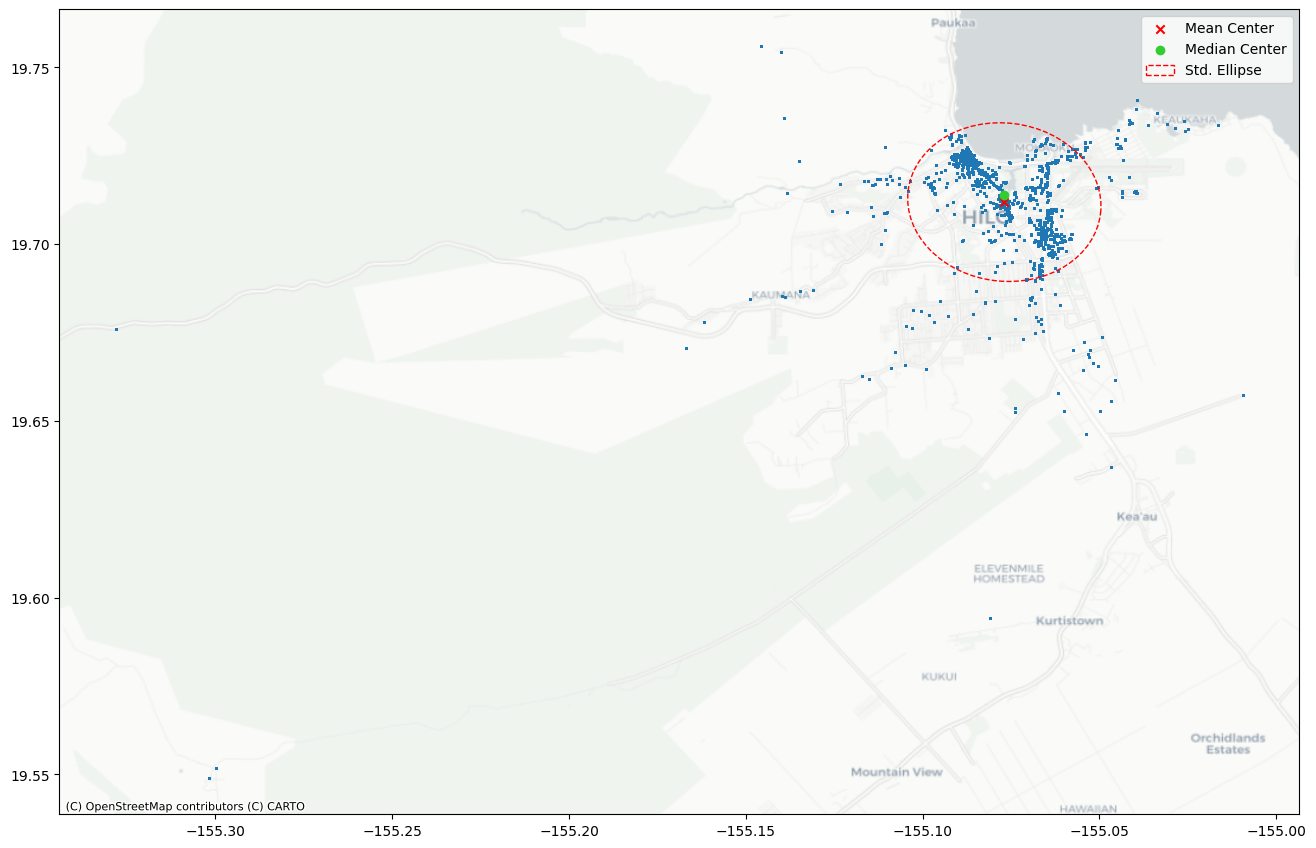

In [208]:
# Standard Deviational Ellipse Graph to evaluate dispersion
from matplotlib.patches import Ellipse

# Compute the axes and rotation
major, minor, rotation = centrography.ellipse(hilo_full[["longitude", "latitude"]])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)

# Plotpoints
ax.scatter(hilo_full["longitude"], hilo_full["latitude"], s=0.5)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()

# Display basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.show()

In [ ]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN

# Define DBSCAN
clusterer = DBSCAN()

# Fit to our data
clusterer.fit(hilo_full[["longitude", "latitude"]])
lbls = pd.Series(clusterer.labels_, index=hilo_full.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 12), dpi=100)

# Subset points that are not part of any cluster (noise)
noise = hilo_full.loc[lbls == -1, ["longitude", "latitude"]]

# Plot noise in grey
ax.scatter(noise["longitude"], noise["latitude"], c="grey", s=5, linewidth=0)

# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    hilo_full.loc[hilo_full.index.difference(noise.index), "longitude"],
    hilo_full.loc[hilo_full.index.difference(noise.index), "latitude"],
    c="red",
    linewidth=0,
)

# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron, crs='EPSG:4326'
)

# Remove axes
ax.set_axis_off()

# Display the figure
plt.show()

In [178]:
# Highest foot traffic near these businesses
# Top 10 businesses with the highest visit counts
hilo_full.sort_values(by="raw_visit_counts", ascending=False)["location_name"].unique()[:10]

array(['Waiakea Center', 'Hilo International Airport',
       'Prince Kuhio Plaza', 'Walmart', 'Target',
       'University Of Hawaii At Hilo', 'Hilo Medical Center',
       'The Home Depot', 'CVS', 'Kta Puainako Pharmacy'], dtype=object)

In [182]:
#hilo_full.info()

In [193]:
# Related same day brands to see what stores people tend to visit on the same day
hilo_full.sort_values(by="related_same_day_brand", ascending=False)["location_name"].unique()[:10]
# Shows stores that have the highest number of associations with other brands visited by the same customers on the same day

array(['Happy Valley Seafood Restaurant', 'St Joseph Preschool',
       'Bamboo Garden',
       "J & R's Lollipops & Things Home of the Original Bradda Pops",
       'My Wireless Hi Hilo Kta Center', 'Pl Seafoods',
       'University Of Hawaii At Hilo', 'Kuwaye Trucking', 'YMCA',
       'The Church of Jesus Christ of Latter Day Saints'], dtype=object)

In [202]:
# Top related same day brand for the top 10 businesses with the highest visit counts
import json

# Top 10 businesses with the highest visit counts
businesses = ['Waiakea Center', 'Hilo International Airport', 'Prince Kuhio Plaza', 
              'Walmart', 'Target', 'University Of Hawaii At Hilo', 
              'Hilo Medical Center', 'The Home Depot', 'CVS', 
              'Kta Puainako Pharmacy']

top_related_brands = {}

for business in businesses:
    # Filter for the current business
    business_data = hilo_full[hilo_full['location_name'] == business].copy()
    
    # Safely convert the JSON string in related_same_day_brand to a list, handling None values
    business_data['related_same_day_brand_list'] = business_data['related_same_day_brand'].apply(
        lambda x: json.loads(x) if x is not None else []
    )
    
    # Explode the DataFrame so each brand has its own row
    all_related_brands = business_data.explode('related_same_day_brand_list')
    
    # Count the most common related same-day brand
    if not all_related_brands.empty:
        top_brand = all_related_brands['related_same_day_brand_list'].value_counts().idxmax()
    else:
        top_brand = 'No data'
    
    # Store the result in the dictionary
    top_related_brands[business] = top_brand

for business, top_brand in top_related_brands.items():
    print(f"{business}: {top_brand}")

Waiakea Center: Walmart
Hilo International Airport: CVS
Prince Kuhio Plaza: CVS
Walmart: CVS
Target: CVS
University Of Hawaii At Hilo: Target
Hilo Medical Center: CVS
The Home Depot: Target
CVS: Target
Kta Puainako Pharmacy: CVS


In [205]:
# Top # related same day brands for the top 10 businesses with the highest visit counts
# The number mapped to each brand is an indicator of how highly correlated a POI is to a certain brand
# The value is a simple percent of POI visitors that visited the other brand on the same day
import json

# Top 10 businesses with the highest visit counts
businesses = ['Waiakea Center', 'Hilo International Airport', 'Prince Kuhio Plaza', 
              'Walmart', 'Target', 'University Of Hawaii At Hilo', 
              'Hilo Medical Center', 'The Home Depot', 'CVS', 
              'Kta Puainako Pharmacy']

top_related_brands = {}

for business in businesses:
    # Filter for the current business
    business_data = hilo_full[hilo_full['location_name'] == business].copy()
    
    # Safely convert the JSON string in related_same_day_brand to a list, handling None values
    business_data['related_same_day_brand_list'] = business_data['related_same_day_brand'].apply(
        lambda x: json.loads(x) if x is not None else []
    )
    
    # Explode the DataFrame so each brand has its own row
    all_related_brands = business_data.explode('related_same_day_brand_list')
    
    # Count the most common related same-day brand
    if not all_related_brands.empty:
        top_brand = all_related_brands['related_same_day_brand_list'].value_counts().nlargest(3)
    else:
        top_brand = 'No data'
    
    # Store the result in the dictionary
    top_related_brands[business] = top_brand

for business, top_brand in top_related_brands.items():
    print(f"{business}: {top_brand}")

Waiakea Center: related_same_day_brand_list
Walmart    35
Texaco     34
Target     34
Name: count, dtype: int64
Hilo International Airport: related_same_day_brand_list
CVS        10
Target      5
Walmart     3
Name: count, dtype: int64
Prince Kuhio Plaza: related_same_day_brand_list
CVS          35
Starbucks    35
Target       32
Name: count, dtype: int64
Walmart: related_same_day_brand_list
CVS               32
Target            31
The Home Depot    16
Name: count, dtype: int64
Target: related_same_day_brand_list
CVS               27
Walmart           26
The Home Depot    11
Name: count, dtype: int64
University Of Hawaii At Hilo: related_same_day_brand_list
Target     13
CVS         8
Walmart     4
Name: count, dtype: int64
Hilo Medical Center: related_same_day_brand_list
CVS         19
Target       6
7-Eleven     3
Name: count, dtype: int64
The Home Depot: related_same_day_brand_list
Target     31
CVS        28
Walmart    24
Name: count, dtype: int64
CVS: related_same_day_brand_list
